In [2]:
# implementation of the quick start section of the pytorch documentation
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor

# The Dataset class stores the data and corresponding labels
# The DataLoader class creates an iterable over the Dataset

# dataset stores samples of data, while the dataloader wraps an iterator around the dataset for ttraining and loading in an efficient way
# Pytorch comes with specific domain libraries such as torchvision, torchtext and torchaudio, which come with specific datasets and functionality for the domain

In [23]:
from torchvision.datasets import FashionMNIST

# torchvision datasets include arguments for transform and target_transform, these are for transfomations to be done to the image and the target variable
def print_target(target):
    return target


# the ToTensor function converts a PIL image to an nd array
training_data = FashionMNIST(root="data", train=True, download=True, transform=ToTensor(), target_transform=print_target)
test_data = FashionMNIST(root="data", train=False, download=True, transform=ToTensor(), target_transform=print_target)

In [31]:
training_data[0][1]

9

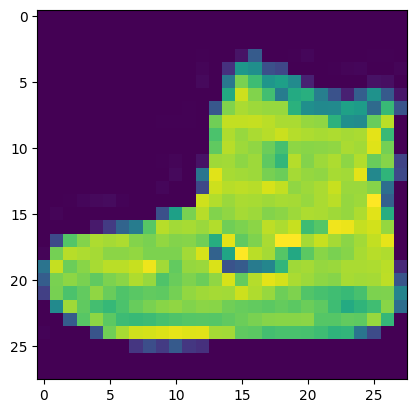

In [26]:
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage

plt.imshow(ToPILImage()(training_data[0][0]))

In [27]:
# Dataset in its natural form would be difficult to work with for training and testing as it would require loading and of every instance
# in the dataset, it is simlpy a list of tuples, we would like to use the dataloader to add the concept of batches to the dataset
# and generally make it easier to use for deep learning training

batch_size = 64

# create a dataloader
training_dataloader = DataLoader(dataset=training_data, batch_size=batch_size, shuffle=True)
testing_dataloader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False) # we dont shuffle test data for obvious reasons

In [29]:
# read first instance of data in dataloader

for X, y in testing_dataloader:
    print(f"The input shape is {X.shape}, the input type is {X.dtype}")
    print(f"The output shape is {y.shape}, the output type is {y.dtype}")
    break

The input shape is torch.Size([64, 1, 28, 28]), the input type is torch.float32
The output shape is torch.Size([64]), the output type is torch.int64


In [39]:
# Creating models with pytorch
torch.backends.mps.is_available() # what are backends? 
mps_backend = "mps"
cpu_backend = "cpu"


In [53]:
class NeuralNetwork(nn.Module): # could also be viewed as multilayer perceptron
    def __init__(self):
        super().__init__() # required to perform backgroud setup
        self.flatten = nn.Flatten() # a flattening layer that will convert any dimensional input into a single dimensional input of specified shape (default is 1)
        self.sequential = nn.Sequential(
            nn.Linear(in_features=28*28, out_features=512), # our input shape is 28*28 because our image was 28 by 28 and has been flattened, our output shape is 512, therefore the shape of the matrix for this layer is (512, 28*28)
            nn.ReLU(), # Rectified Linear unit activation function to add non-linearity to the network, this will set all negative values to zero while preserving all positive values
            nn.Linear(in_features=512, out_features=512), # The is anothe hidden layer with matrix of shape (512,512)
            nn.ReLU(),  # Another activation function to add non-linearity to the network
            nn.Linear(in_features=512, out_features=10), # this is the final layer/output layer with outputs of size 10, to represent the 10 classes we are trying to classify matrix (10, 512)
            # nn.Softmax(10)
        )
        
    def forward(self, x):
        x = self.flatten(x)
        logits = self.sequential(x)
        return logits
        

In [54]:
# build network
model = NeuralNetwork().to(mps_backend)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (sequential): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [63]:
# define loss function and optimization technique
loss = nn.CrossEntropyLoss() # returns a callable class
optimizer= torch.optim.SGD(params=model.parameters(), lr=0.01)

In [68]:
def train(dataloader: DataLoader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)  # get the size of the entire training data
    losses = []
    batches = []
    
    model.train() # ???
    for batch, (X, y) in enumerate(dataloader):
        # set the X, y values to the appropriate device for easier computation
        X = X.to(mps_backend)
        y = y.to(mps_backend)
        
        # find the prediction of the model
        pred = model(X)
        # calculate the loss of the prediction
        loss = loss_fn(pred, y)
        
    
        # Learning / Code writing process    
        optimizer.zero_grad() # set the previous gradients to zero, probably from the previous training step, this is because the gradients are culmulative
        loss.backward() # calculate the gradient for every value in the computational graph
        optimizer.step() # adjust the values for the specified values of the parameters based on their gradients using the defined optimization techniqe
        
        # get information for plotting graph
        losses.append(loss.item())
        batches.append(batch)
        
        if batch % 100 == 0:
            # will print if the batch is a multiple of 100
            loss, current = loss.item(), (batch + 1) * len(y)
            print(f" Loss : {loss:>7f} [Current : {current:>5d}/{size:>5d}]")
    plt.plot(batches, losses)

In [50]:
def test(dataloader: DataLoader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval() # ??
    test_loss, correct = 0, 0
    
    torch.no_grad() # ??
    
    for X, y in dataloader:
        X, y = X.to(mps_backend), y.to(mps_backend)
        pred = model(X)
        test_loss += loss_fn(pred, y).item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        
    test_loss /= num_batches
    correct /= size
    
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss


Epoch 0 ................................
 Loss : 0.290171 [Current :    64/60000]
 Loss : 0.112815 [Current :  6464/60000]
 Loss : 0.221523 [Current : 12864/60000]
 Loss : 0.247181 [Current : 19264/60000]
 Loss : 0.108084 [Current : 25664/60000]
 Loss : 0.279756 [Current : 32064/60000]
 Loss : 0.140997 [Current : 38464/60000]
 Loss : 0.188168 [Current : 44864/60000]
 Loss : 0.268091 [Current : 51264/60000]
 Loss : 0.360601 [Current : 57664/60000]
Test Error: 
 Accuracy: 89.5%, Avg loss: 0.299047 

Epoch 1 ................................
 Loss : 0.112991 [Current :    64/60000]
 Loss : 0.150910 [Current :  6464/60000]
 Loss : 0.230168 [Current : 12864/60000]
 Loss : 0.265144 [Current : 19264/60000]
 Loss : 0.201005 [Current : 25664/60000]
 Loss : 0.163003 [Current : 32064/60000]
 Loss : 0.239921 [Current : 38464/60000]
 Loss : 0.151739 [Current : 44864/60000]
 Loss : 0.188313 [Current : 51264/60000]
 Loss : 0.080658 [Current : 57664/60000]
Test Error: 
 Accuracy: 89.3%, Avg loss: 0.300

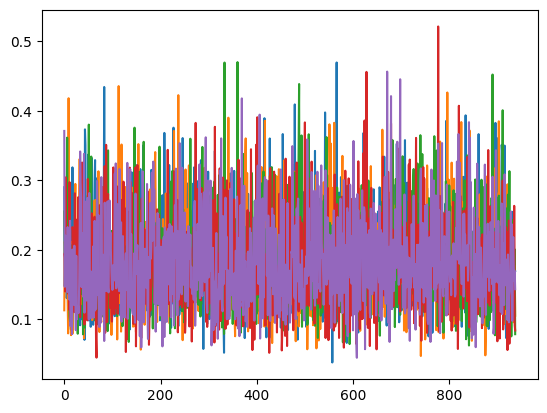

In [69]:
# perform actual training over defined amount of epochs
epochs = 5
avg_losses = []
epoch_list = []
for epoch in range(epochs):
    print(f"Epoch {epoch} ................................")
    train(training_dataloader, model, loss, optimizer)
    avg_loss = test(testing_dataloader, model, loss)
    avg_losses.append(avg_loss)
    epoch_list.append(epoch)

print("Done")

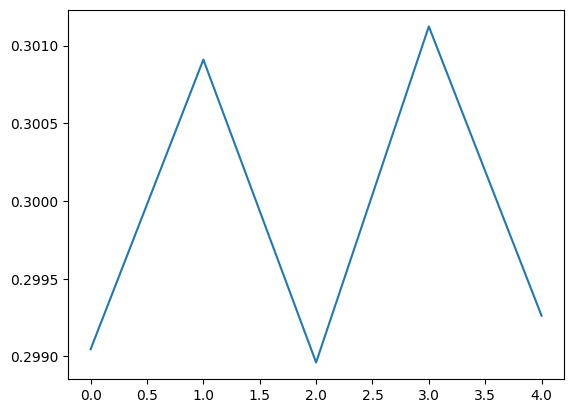

In [70]:
plt.plot(epoch_list, avg_losses)

In [73]:
# Save the model with pytorch API
torch.save(model.state_dict(), "model.pth")
print_target("Pytorch FashionMNIST model saved")

'Pytorch FashionMNIST model saved'

In [74]:
fmnist = NeuralNetwork()
fmnist.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

In [76]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
X, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    X = X.to(mps_backend)
    pred = model(X)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


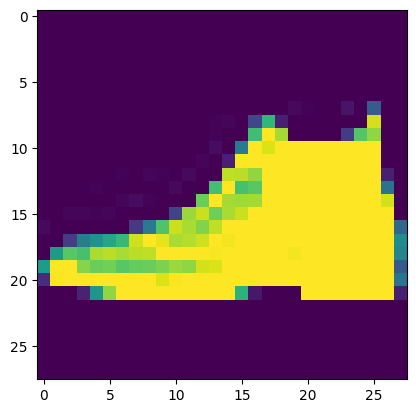

In [77]:
plt.imshow(ToPILImage()(X))